In [1]:
#Assert working directories
import os
os.getcwd()

'C:\\Users\\midhu\\Documents\\GitHub\\Save_and_continue'

In [2]:
from alpha import random_mini_batch, load_data, plot_images, plot_confusion_matrix, misclassified_images, plot_images_misclassified, iterate_minibatches
from cnn_utils import create_placeholders, conv_layer, compute_cost

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from tqdm import tqdm as tqdm #For professional progress-bar
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [4]:
TRAIN_DIR = "./train"
IMG_SIZE = 99 #If changing, change in alpha.py as well
img_shape = (IMG_SIZE,IMG_SIZE,3)
num = 500

In [5]:
train, label= load_data(num, IMG_SIZE, DIR =TRAIN_DIR)

90it [00:00, 124.11it/s]
90it [00:00, 273.57it/s]
90it [00:00, 127.30it/s]


In [6]:
type(label), type(train), label.shape, train.shape

(numpy.ndarray, numpy.ndarray, (270, 1), (270, 99, 99, 3))

In [7]:
label_df = pd.DataFrame(label, columns = ['classes'])
label_df.head()

,classes
0,Oil Filter
1,Oil Filter
2,Fuel Filter
3,AC Filter
4,AC Filter


In [8]:
label_unique = label_df.classes.unique()
label_unique

array(['Oil Filter', 'Fuel Filter', 'AC Filter'], dtype=object)

In [9]:
en = LabelEncoder()
en.fit(label_df.classes)
encoded_label = en.transform(label_df.classes)
label_df["encoded_label"] = encoded_label
label_df.head()

,classes,encoded_label
0,Oil Filter,2
1,Oil Filter,2
2,Fuel Filter,1
3,AC Filter,0
4,AC Filter,0


In [10]:
#Create one hot matrix
one_hot_label = (np.arange(3) == encoded_label[:,None]).astype(np.float32)

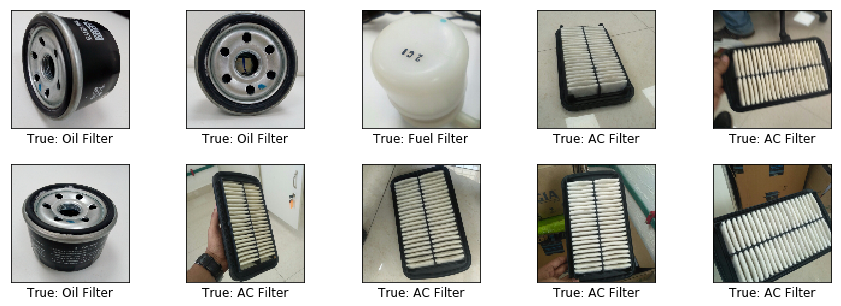

In [11]:
#get 10 images to plot
images = train[:10]
true_class = label_df.classes[:10]
plot_images(images, true_class)

Split the data

In [12]:
#Total 240 images; 
x_train = train[:-50,:,:,:]# upto (240-40) for train 
x_val = train[-50:,:,:,:]#from (240-40) for validation set

In [13]:
y_train = one_hot_label[:-50,:]
y_val = one_hot_label[-50:,:]
label_val = np.array(label_df["classes"].iloc[-50:]) #for confusion matrix
encoded_label_val = encoded_label[-50:] #for confusion matrix in the end

In [14]:
label_val[:5], encoded_label_val[:5]

(array(['Oil Filter', 'Fuel Filter', 'Oil Filter', 'AC Filter', 'AC Filter'], dtype=object),
 array([2, 1, 2, 0, 0], dtype=int64))

In [15]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((220, 99, 99, 3), (220, 3), (50, 99, 99, 3), (50, 3))

CNN Model

In [25]:
#Model
def model(X_train, Y_train, X_val, Y_val, learning_rate = 0.005, num_epochs = 2, minibatch_size = 64):
    
    tf.reset_default_graph() #Clear the graph
    
    #iteration = tf.Variable(0, name="iteration", trainable=False)
    global_step = tf.Variable(0, name="global_sstep", trainable=False)
    
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    #Conv layers
    conv1 = conv_layer(X,     3,  10,  "conv1")
    conv2 = conv_layer(conv1, 10,  16, "conv2")
    conv3 = conv_layer(conv2, 16, 32, "conv3")
    conv4 = conv_layer(conv3, 32, 64, "conv4")
    conv5 = conv_layer(conv4, 64, 128, "conv5")
    flattened = tf.contrib.layers.flatten(conv5)
    
    #FC layers
    fc1 = tf.contrib.layers.fully_connected(flattened, 128, activation_fn = None)
    Z   = tf.contrib.layers.fully_connected(fc1,       3,   activation_fn = None)
    prob = tf.nn.softmax(Z, name="probs")
    prediction = tf.argmax(Z, 1, name="prediction")
    
    cost = compute_cost(Z, Y)    

    with tf.name_scope("optimize"):
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step=global_step)
    
    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(Z, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar("accuracy", accuracy)
    
    summaryMerged = tf.summary.merge_all() #Merge all summaries
    filename="./summary_log/run-"+time.strftime("%d%m-%H%M%S") #Name and directory for summary
    
    #Saver
    saver = tf.train.Saver()
    
    #Add every variable inside session which you need to acces for prediction to collection for meta graph to import later; 
    #Efficient way than creating functions and creating graphs from scratch;
    #Can be do before session starts;
    tf.add_to_collection('Z', Z)
    tf.add_to_collection('X', X)
    tf.add_to_collection('correct_prediction', correct_prediction)
   

   
    with tf.Session() as sess:
        #sess.run(tf.global_variables_initializer())  #For the very first run; comment it off for future run
        saver.restore(sess, tf.train.latest_checkpoint('.\\saved_model')) #Comment it off during first run
        writer = tf.summary.FileWriter(filename, sess.graph) 
    
        for epoch in range(num_epochs):
            avg_cost = 0
            #num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            #minibatches = random_mini_batch(X_train, Y_train, minibatch_size)
            
            for i, minibatch in enumerate(iterate_minibatches(X_train, Y_train, minibatch_size)):
            
                (minibatch_X, minibatch_Y) = minibatch
                
                sess.run(optimizer, feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                avg_cost += sess.run(cost, feed_dict={X: minibatch_X, Y: minibatch_Y})
                #avg_cost += cost 
                   
                iteration = sess.run(global_step)
                
                #Write logs
                #if iteration>15 : #Optional; since the graph hit high during starting
                summ = sess.run(summaryMerged, feed_dict={X: minibatch_X, Y: minibatch_Y})
                writer.add_summary(summ, (iteration))
               
                #Print logs
            #if iteration % 10 ==0:
            print ("Cost after iteration %i: %f " % (iteration, avg_cost/(i+1)))
        
        print("Training completed!!") #Got out from the loop;
        
        #Save weights
        saver.save(sess, "./saved_model/model")
        
        # Export MetaGraphDef 
        tf.train.export_meta_graph(filename='./meta/model.meta')
      
        #Model accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))*100
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_val, Y: Y_val})
        
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        print("Total iterations completed : ", iteration)
        
        #One step forwardprop
        predict_op = tf.argmax(Z, 1) 
        pred = sess.run(predict_op, feed_dict={X: X_val})
        
    return pred

In [26]:
#no dropout
pred= model(x_train, y_train, x_val, y_val, num_epochs = 1, minibatch_size = 20, learning_rate = 0.005)

INFO:tensorflow:Restoring parameters from .\saved_model\model
Cost after iteration 121: 0.000229 
Training completed!!
Train Accuracy: 100.0
Test Accuracy: 90.0
Total iterations completed :  121


In [27]:
from tensorflow.python.framework.graph_util_impl import convert_variables_to_constants

In [28]:
graph2 = tf.Graph()
with tf.Session(graph=graph2) as sess:
    
    saver = tf.train.import_meta_graph('./saved_model/model.meta')
    input_graph_def = tf.get_default_graph().as_graph_def()
    saver.restore(sess, "./saved_model/model")

    output_node_names="prediction,probs"
    output_graph_def = convert_variables_to_constants(sess,
                                                      input_graph_def,
                                                      output_node_names.split(","))
    

    output_graph="./ltdcnn.pb"
    print("Writing to proto buff file")
    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(output_graph_def.SerializeToString())

INFO:tensorflow:Restoring parameters from ./saved_model/model
INFO:tensorflow:Froze 14 variables.
Converted 14 variables to const ops.
Writing to proto buff file


In [ ]:
decoded_label_val = en.inverse_transform(pred)

In [ ]:
#get 10 images to plot
images = x_val[:10]
cls_true = label_val[:10]
cls_pred = decoded_label_val[:10]
plot_images(images, cls_true, cls_pred)

In [ ]:
plot_confusion_matrix(label_val, decoded_label_val, label_unique)

In [ ]:
#Misclassified images
miss = misclassified_images(encoded_label_val, pred)

In [ ]:
images = x_val[miss]
true_cls = label_val[miss]
pred_cls = decoded_label_val[miss]
plot_images_misclassified(images, true_cls, pred_cls, miss)